In [40]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, DenseNet121, ResNet50, InceptionV3, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Reshape, Multiply, Lambda, Attention, Input
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [10]:
test_folder='/Users/abhi/Documents/F_yera_proj/dangerous farm insects/Test farm_insects'
train_folder='/Users/abhi/Documents/F_yera_proj/dangerous farm insects/Training farm_insects'
validation_folder = '/Users/abhi/Documents/F_yera_proj/dangerous farm insects/Validation farm_insects'

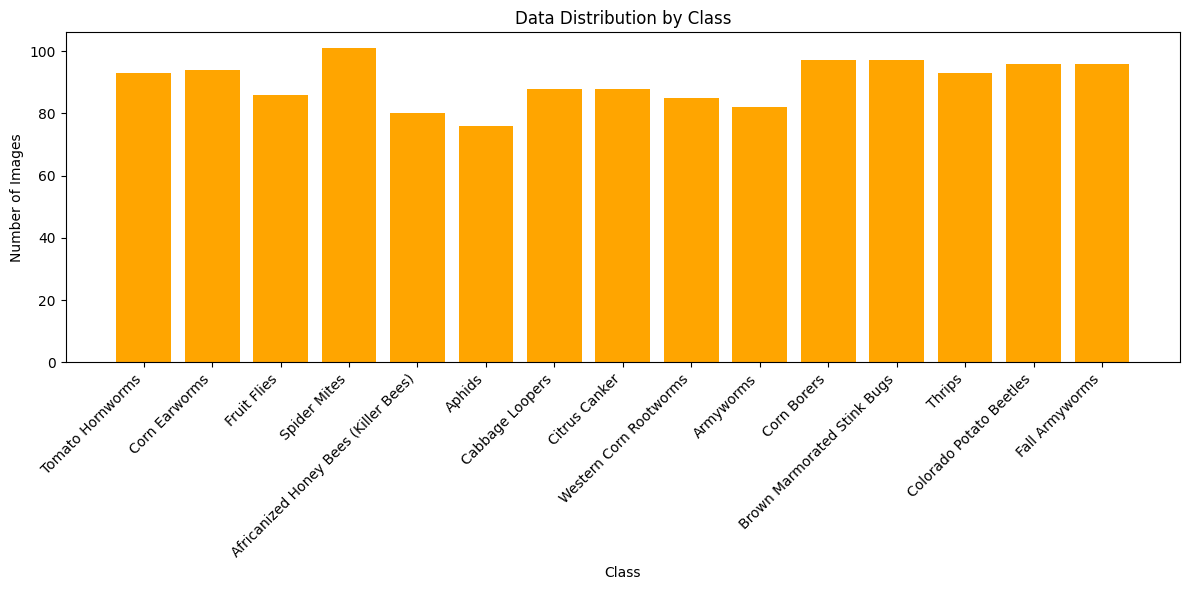

In [3]:
# import os
# import matplotlib.pyplot as plt

# # Replace 'dataset_path' with the path to your dataset
# dataset_path = train_folder

# # Get the list of class folders
# class_folders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# # Initialize lists to store class names and corresponding image counts
# class_names = []
# image_counts = []

# # Iterate through each class folder
# for class_folder in class_folders:
#     # Construct the full path to the class folder
#     class_path = os.path.join(dataset_path, class_folder)
    
#     # Count the number of images in the class folder
#     num_images = len(os.listdir(class_path))
    
#     # Append class name and image count to lists
#     class_names.append(class_folder)
#     image_counts.append(num_images)

# # Plotting the data distribution
# plt.figure(figsize=(12, 6))
# plt.bar(class_names, image_counts, color='orange')
# plt.xlabel('Class')
# plt.ylabel('Number of Images')
# plt.title('Data Distribution by Class')
# plt.xticks(rotation=45, ha='right')

# # Show the plot
# plt.tight_layout()
# plt.show()


In [29]:
input_shape = (224, 224, 3) 
num_classes = 15
batch_size = 16

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,          # Rescale pixel values
    rotation_range=30,         # Random rotation up to 30 degrees
    zoom_range=0.2,            # Random zoom up to 20%
    width_shift_range=0.2,     # Random horizontal shift up to 20%
    height_shift_range=0.2,    # Random vertical shift up to 20%
    horizontal_flip=True,      # Random horizontal flip
    vertical_flip=True,        # Random vertical flip
    fill_mode='nearest',        # Fill mode for newly created pixels
)

In [31]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=input_shape[:2],
    batch_size=16,
    class_mode='categorical',
    subset='training' 
    )

Found 1072 images belonging to 15 classes.


In [32]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=input_shape[:2],
    batch_size=16,
    class_mode=None,  
    shuffle=False)

Found 308 images belonging to 15 classes.


In [33]:
validation_generator = train_datagen.flow_from_directory(
    validation_folder,
    target_size=input_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

Found 200 images belonging to 15 classes.


# Applying MobileNet model

In [ ]:
base_model = MobileNetV2(
    input_shape=input_shape,  # Input shape of the images
    include_top=False,  # Exclude the fully connected layers at the top
    weights='imagenet')   # Use pre-trained weights on ImageNet
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
x = base_model.output
# Separate query and value features
query = GlobalAveragePooling2D()(x)
value = GlobalAveragePooling2D()(x)

# Add attention layer
x = Attention()([query, value])

x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation='relu')(x)


# Continue with the rest of your model architecture
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
history=model.fit(train_generator,
        steps_per_epoch=train_generator.samples // batch_size, 
        epochs=30, 
        validation_data=validation_generator, 
        validation_steps=validation_generator.samples // batch_size
        )

Epoch 1/30
 4/84 [>.............................] - ETA: 23s - loss: 3.0606 - accuracy: 0.0781   

/Users/abhi/Documents/F_yera_proj/.conda/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


84/84 [==============================] - 28s 320ms/step - loss: 2.2483 - accuracy: 0.2887 - val_loss: 1.4654 - val_accuracy: 0.5402
Epoch 2/30
84/84 [==============================] - 25s 302ms/step - loss: 1.6114 - accuracy: 0.4940 - val_loss: 1.1037 - val_accuracy: 0.6786
Epoch 3/30
84/84 [==============================] - 25s 299ms/step - loss: 1.4024 - accuracy: 0.5474 - val_loss: 1.0203 - val_accuracy: 0.6920
Epoch 4/30
84/84 [==============================] - 26s 307ms/step - loss: 1.2242 - accuracy: 0.5947 - val_loss: 1.0740 - val_accuracy: 0.6339
Epoch 5/30
 8/84 [=>............................] - ETA: 20s - loss: 1.0891 - accuracy: 0.6250

KeyboardInterrupt: 

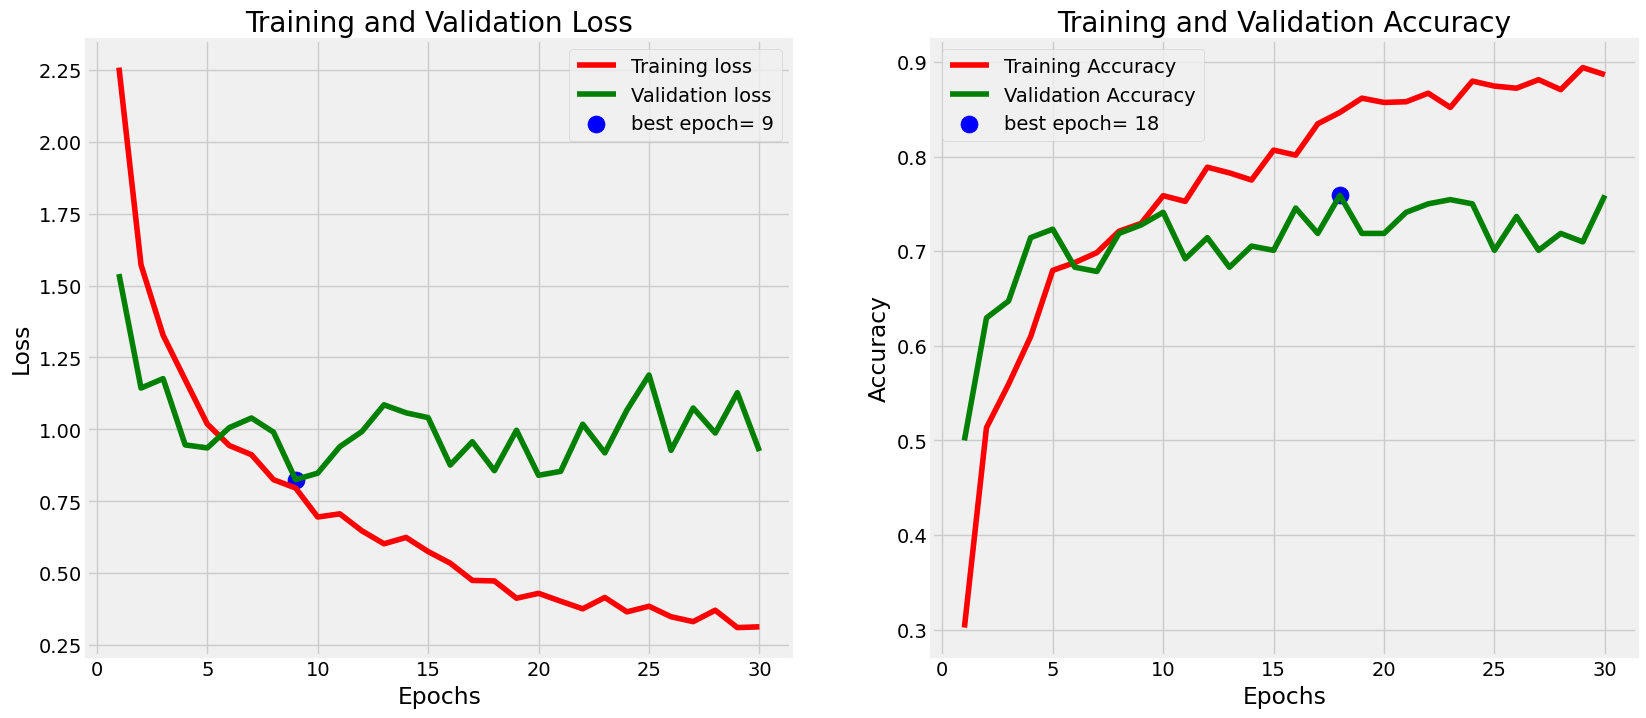

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

plot_training(history)

In [ ]:
model.save('final_90.h5')

/Users/abhi/Documents/F_yera_proj/.conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model=load_model('/Users/abhi/Documents/F_yera_proj/xception_attention_model3.h5')

In [ ]:
predictions = model.predict(validation_generator)

 4/15 [=======>......................] - ETA: 2s

/Users/abhi/Documents/F_yera_proj/.conda/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 4s 263ms/step


In [ ]:
loss, accuracy=model.evaluate(validation_generator)

15/15 [==============================] - 4s 225ms/step - loss: 0.9175 - accuracy: 0.7607


In [ ]:
accuracy

0.7606837749481201

In [ ]:
loss, accuracy=model.evaluate(train_generator)

85/85 [==============================] - 23s 263ms/step - loss: 0.2295 - accuracy: 0.9198


In [ ]:
accuracy

0.9197622537612915

# Testing Accuracy of the trained model

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(validation_generator.class_indices.keys())
predicted_labels = [class_labels[prediction] for prediction in predicted_classes]

In [ ]:
actual_class_names = [class_labels[label] for label in validation_generator.classes]
print(classification_report(actual_class_names, predicted_labels))

                                      precision    recall  f1-score   support

Africanized Honey Bees (Killer Bees)       0.07      0.06      0.06        16
                              Aphids       0.00      0.00      0.00        12
                           Armyworms       0.05      0.08      0.06        13
         Brown Marmorated Stink Bugs       0.06      0.06      0.06        17
                     Cabbage Loopers       0.00      0.00      0.00        16
                       Citrus Canker       0.06      0.06      0.06        16
             Colorado Potato Beetles       0.00      0.00      0.00        16
                         Corn Borers       0.06      0.06      0.06        17
                       Corn Earworms       0.05      0.06      0.05        16
                      Fall Armyworms       0.00      0.00      0.00        16
                         Fruit Flies       0.13      0.14      0.14        14
                        Spider Mites       0.14      0.11      

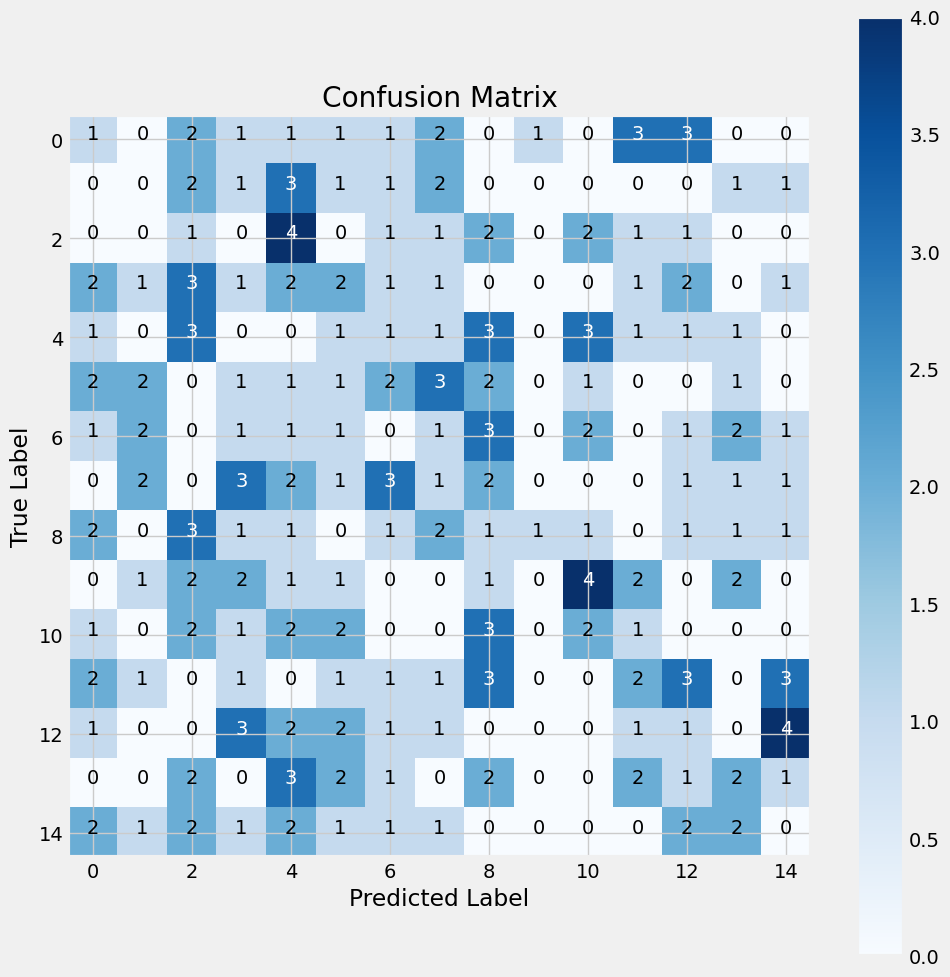

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(actual_class_names, predicted_labels, labels=class_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation= 45)
# plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

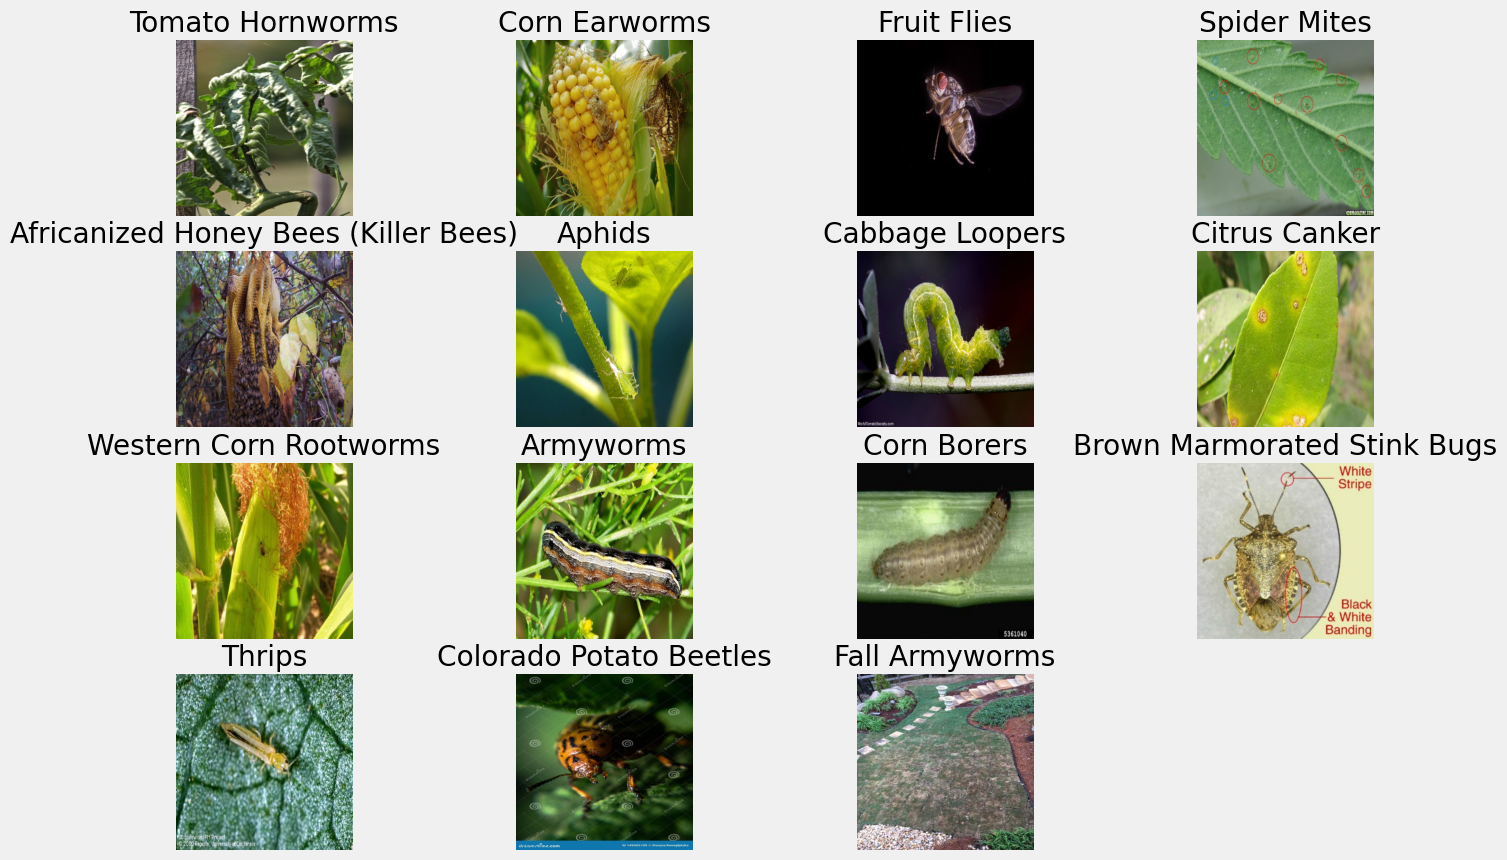

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import math

# Path to the test folder
# test_folder = '/path/to/your/test/folder'

# Get a list of class folders in the test folder
class_folders = [f for f in os.listdir(test_folder) if os.path.isdir(os.path.join(test_folder, f))]

# Determine the layout of subplots
num_classes = len(class_folders)
num_cols = min(4, num_classes)  # Maximum 4 columns for better visualization
num_rows = math.ceil(num_classes / num_cols)

# Plot one image from each class
plt.figure(figsize=(15, 10))
for i, class_folder in enumerate(class_folders):
    # Get a list of image files in the current class folder
    class_folder_path = os.path.join(test_folder, class_folder)
    image_files = [f for f in os.listdir(class_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a random image from the current class
    random_image = random.choice(image_files)
    image_path = os.path.join(class_folder_path, random_image)

    # Open and plot the image
    img = Image.open(image_path)

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    plt.title(f"{class_folder}")
    plt.axis('off')

plt.show()


# Training DenseNet model

In [ ]:
base_model1 = DenseNet121(
    include_top=False,  
    weights='imagenet',  
    input_shape=(224, 224, 3)  
)
base_model1.summary()

29097984/29084464 [==============================] - 9s 0us/step


In [ ]:
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
for layer in base_model1.layers:
    layer.trainable = False

In [ ]:
model1 = Model(inputs=base_model1.input, outputs=predictions)

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model1.fit(train_generator,
        steps_per_epoch=train_generator.samples // batch_size, 
        epochs=10, 
        validation_data=validation_generator, 
        validation_steps=validation_generator.samples // batch_size
        )

Epoch 1/2
80/80 [==============================] - 354s 4s/step - loss: 2.1834 - accuracy: 0.3249
Epoch 2/2
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/abhi/opt/anaconda3/envs/aii/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-143-ec7bb9d8f00c>", line 1, in <cell line: 1>
    model1.fit(train_generator, epochs=2)
  File "/Users/abhi/opt/anaconda3/envs/aii/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
  File "/Users/abhi/opt/anaconda3/envs/aii/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
  File "/Users/abhi/opt/anaconda3/envs/aii/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/Users/abhi/opt/anaconda3/envs/aii/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
  File "/Users/abhi/opt/anaconda3/envs/aii/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line

In [ ]:
model1.save('dense net.h5')

# Training ResNet50 model

In [ ]:
base_model2 = ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)  
)
base_model2.summary()

2023-08-23 10:17:34.622338: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-23 10:17:34.622588: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-23 10:17:34.622606: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-23 10:17:34.622688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-23 10:17:34.623102: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


94765736/94765736 [==============================] - 28s 0us/step


In [ ]:
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
for layer in base_model2.layers:
    layer.trainable = False

In [ ]:
model2 = Model(inputs=base_model2.input, outputs=predictions)

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.fit(train_generator,
        steps_per_epoch=train_generator.samples // batch_size, 
        epochs=10, 
        validation_data=validation_generator, 
        validation_steps=validation_generator.samples // batch_size
        )

2023-08-23 10:22:00.722742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 54s 583ms/step - loss: 3.0189 - accuracy: 0.1091


# Training InceptionV3 model

In [ ]:
base_model3 = InceptionV3(
    include_top=False,  
    weights='imagenet',  
    input_shape=(224, 224, 3)
)
base_model3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 111, 111, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 111, 111, 32)         96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
x = base_model3.output
x1 = GlobalAveragePooling2D()(x)
x2 = GlobalAveragePooling2D()(x)
x = Attention()([x1, x2])
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
for layer in base_model3.layers:
    layer.trainable = False

In [ ]:
model3 = Model(inputs=base_model3.input, outputs=predictions)

In [ ]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model3.fit(train_generator,
        steps_per_epoch=train_generator.samples // batch_size, 
        epochs=10, 
        validation_data=validation_generator, 
        validation_steps=validation_generator.samples // batch_size
        )

2023-08-23 10:27:14.659702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 48s 460ms/step - loss: 2.7091 - accuracy: 0.1581


# Training Xception model

In [ ]:
base_model4 = Xception(
    include_top=False,  # Exclude the fully connected layers at the top
    weights='imagenet',  # Use pre-trained weights on ImageNet
    input_shape=(299, 299, 3)  # Input shape of your images (Xception requires 299x299)
)
base_model4.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [ ]:
def attention_block(input_tensor, attention_size=2048, spatial_dimensions=(10, 10)):
    attention = Dense(attention_size, activation='relu')(input_tensor)
    attention = Dense(1, activation='softmax')(attention)

    # Flatten the attention tensor
    attention = Flatten()(attention)

    # Expand dimensions for broadcasting
    attention = attention[:, None, None, None]

    # Tile the attention tensor along spatial dimensions using broadcasting
    attention = attention * tf.ones((1, spatial_dimensions[0], spatial_dimensions[1], 1))

    # Expand dimensions of the input tensor to match the attention tensor's shape
    input_tensor_expanded = input_tensor[:, None, None, :]

    # Multiply the tensors element-wise
    attention = Multiply()([input_tensor_expanded, attention])

    return attention


In [ ]:
x = base_model4.output
attention = attention_block(x)
attention = Dense(2048)(attention)
gap = GlobalAveragePooling2D()(x)
combined = Concatenate()([gap, attention])
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

ValueError: Inputs have incompatible shapes. Received shapes (1, 1, 10, 10, 2048) and (1, 10, 10, 100)

In [ ]:
for layer in base_model4.layers:
    layer.trainable = False

In [ ]:
model4 = Model(inputs=base_model4.input)

In [ ]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model4.fit(train_generator,
        steps_per_epoch=train_generator.samples // batch_size, 
        epochs=30, 
        validation_data=validation_generator, 
        validation_steps=validation_generator.samples // batch_size
        )

Epoch 1/30


ValueError: in user code:

    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/abhi/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, None, None, 15) are incompatible


In [ ]:
def solve(n, arr):
    count=0
    element_count = {}
    
    for element in arr:
        if element in element_count:
            element_count[element] += 1
        else:
            element_count[element] = 1

    for val in element_count.values():
        count+=val//2

    if count == 0:
        count = "No pairs found"

    
    return count

def main():
    arr=[567, 206, 40, 195, 647, 81, 40, 339, 40, 797, 40]
    print(solve(len(arr), arr))

main()

2


In [ ]:
def solve(n, arr):
    count = 0
    element_count = {}
    
    for element in arr:
        if element in element_count:
            element_count[element] += 1
        else:
            element_count[element] = 1

    for val in element_count.values():
        count += val // 2
    
    return count

def main():
    arr = [567, 206, 40, 195, 647, 81, 40, 339, 40, 797, 40]
    count = solve(len(arr), arr)
    print(count)

main()


2
11


In [ ]:
6, 1, 6, 5, 1, 2, 8, 2, 9, 2, 4

In [ ]:
str=input()
new_s=''
for i in range(len(str)):
    new_s+=str[i]
    new_s+=str[i]

print(new_s)

hheelllloowwoorrlldd


In [ ]:
level=3
arr=[6, 1, 6, 5, 1, 2, 8, 2, 9, 2, 4]
node_s=0
node_e=1
for i in range(1, level):
    node_s += node_e+1
    node_e += 2**i


print(sum(arr[node_s-1:node_e]))



10


In [ ]:
level = 2
arr = [6, 1, 6, 5, 1, 2, 8, 2, 9, 2, 4]
node_s = 1
node_e = 2

# Calculate node_s and node_e for the specified level
for i in range(1, level):
    node_s = 2 * node_s + 1
    node_e = 2 * node_e + 1

# Calculate the sum of elements at the specified level
level_sum = sum(arr[node_s:node_e])
print(level_sum)


6


In [46]:
def printResult(strs):
    tw = len(strs.split())
    cw = sum(1 for word in strs.split() if word[0].isupper())
    per = (cw / tw) * 100

    if per <= 20:
        print("Not Important")
    elif per <= 60:
        print("Moderately Important")
    elif per <= 75:
        print("Important")
    else:
        print("Most Important")

# WRITE YOUR CODE HERE.

def main():
    n = 1

    for i in range(n):
        strs = "DS9s MAH790 10px5 4RILQ ggvx W031 1Y5b sc1f Vhrt ruo Xef al ADQeq ONYEHS1 Mis SGSy at303 XFE76 BvBxf Htdw H8sb5 bz3q0V7 LKa ulXB spQi Gva NucLEb9R"
        printResult(strs)

if _name_ == "_main_":
    main()

printResults('DS9s MAH790 10px5 4RILQ ggvx W031 1Y5b sc1f Vhrt ruo Xef al ADQeq ONYEHS1 Mis SGSy at303 XFE76 BvBxf Htdw H8sb5 bz3q0V7 LKa ulXB spQi Gva NucLEb9R')

NameError: name '_name_' is not defined

In [47]:
import heapq

def r(n, nums, x, y):
    for pair in zip(x, y):
        heapq.heappush(pq, Element(*pair))
    h = [(-p, v) for v, p in e]
    heapq.heapify(h)
    result = [heapq.heappop(h)[1] for _ in range(len(h))]
    return result

n = int(input())
e = [tuple(map(int, input().split())) for _ in range(n)]
k = int(input())

print(*r(n, e, k))


# Concatinated model

In [28]:
mobilenet = load_model('F_yera_proj/mobile net.h5')
densenet = load_model('F_yera_proj/dense net.h5')
xception = load_model('F_yera_proj/xception_attention_model3.h5')

# Remove the final classification layer from each model
mobilenet = Model(inputs=mobilenet.input, outputs=mobilenet.layers[-2].output)
densenet = Model(inputs=densenet.input, outputs=densenet.layers[-2].output)
xception = Model(inputs=xception.input, outputs=xception.layers[-2].output)

In [37]:
inputs = Input(shape=input_shape)

# Get the outputs of the pre-trained models
mobilenet_output = mobilenet(inputs)
densenet_output = densenet(inputs)
xception_output = xception(inputs)

# Ensure the outputs are 2D tensors
mobilenet_output = tf.keras.layers.Flatten()(mobilenet_output)
densenet_output = tf.keras.layers.Flatten()(densenet_output)
xception_output = tf.keras.layers.Flatten()(xception_output)

# Concatenate the outputs
concatenated = Concatenate()([mobilenet_output, densenet_output, xception_output])

In [41]:
x = Dense(1024, activation='relu')(concatenated)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
ensemble_model = Model(inputs=inputs, outputs=predictions)

# Compile the model
ensemble_model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
ensemble_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  2421952   ['input_2[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 128)                  7168704   ['input_2[0][0]']             
                                                                                                  
 model_2 (Functional)        (None, 2048)                 2086148   ['input_2[0][0]']             
                                                          0                                 

In [42]:
# Train the model
ensemble_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
 1/67 [..............................] - ETA: 17:09 - loss: 2.7948 - accuracy: 0.0000e+00

/opt/homebrew/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


49/67 [====================>.........] - ETA: 56s - loss: 1.6920 - accuracy: 0.4834

KeyboardInterrupt: 